# A plugin to add text callouts to a scatter plot interactively

User story: as a graph maker, I want to include text to callout specific outlier data points, in a visually appealing way.  It would be convenient to do this interactively, and then be able to save the results for later.


Requirements:

* click on a point to reveal the text callout
* drag the text to move it to a better place
* include a line from the text to the point (if necessary)
* save results

In [1]:
import matplotlib.pyplot as plt, numpy as np, mpld3
%matplotlib inline
mpld3.enable_notebook()

In [2]:
# set random seed for reproducible results
np.random.seed(123456789)

In [3]:
xx = np.random.laplace(size=100)
yy = np.random.laplace(size=100)
ss = map(lambda x: 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[x], np.random.randint(26, size=100))

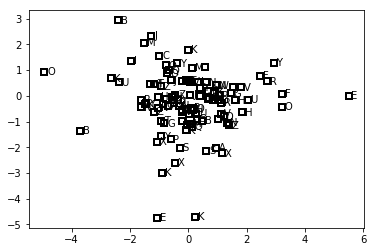

In [4]:
# the problem: too many text callouts, too close together

plt.plot(xx, yy, linestyle='none', marker='s', mew=2, mec='k', mfc='none')
for s_i, x_i, y_i in zip(ss, xx, yy):
    plt.text(x_i+.1, y_i, s_i, ha='left', va='center')

TypeError: Object of type 'map' is not JSON serializable

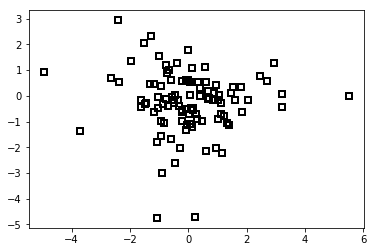

In [6]:
# the solution: a plugin so that the text is only revealed when a marker is clicked
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

class CalloutPlugin(mpld3.plugins.PluginBase):
    JAVASCRIPT = r"""
    mpld3.register_plugin("callout", CalloutPlugin);
    CalloutPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    CalloutPlugin.prototype.constructor = CalloutPlugin;
    CalloutPlugin.prototype.requiredProps = ["id"];
    CalloutPlugin.prototype.defaultProps = {labels: null}
    
    var my_icon = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAIAAACQkWg2AAAACXBIWXMAAAsTAAALEwEAmpwYAAAAB3RJTUUH3gUTDC0v7E0+LAAAAB1pVFh0Q29tbWVudAAAAAAAQ3JlYXRlZCB3aXRoIEdJTVBkLmUHAAAAa0lEQVQoz32QQRLAIAwCA///Mz3Y6cSG4EkjoAsk1VgAqspecVP3TTIA6MHTQ6sOHm7Zm4dWHcC4wc3hmVzT7xEbYf66dX/xnEOI7M9KYgie6qvW6ZH0grYOmQGOxzCEQn8C5k5mHAOrbeIBWLlaA3heUtcAAAAASUVORK5CYII=";

    function CalloutPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
        // add a button to enable/disable box zoom
        var SaveButton = mpld3.ButtonFactory({
            buttonID: "save",
            sticky: false,
            onActivate: function(){save_callouts(this.props.callouts);}.bind(this),
            icon: function(){return my_icon;},
        });
        this.fig.buttons.push(SaveButton);
    };

    function save_callouts(callouts) {
      function callout_py(d) {
        return "plt.text(" + d.x + ", " + d.y + ", '" + d.s + "', va='center')\n"
          + "plt.plot([" + d.x1 + ", " + d.x2 + "], [" + d.y1 + ", " + d.y2 + "], 'k-')\n"
      }
      prompt("Copy code to generate callouts:", callouts.map(callout_py).join("\n"));
    }

    CalloutPlugin.prototype.draw = function(){
        mpld3.t = this; // for debugging and interactive development
        this.props.callouts = [];
        
        var obj = mpld3.get_element(this.props.id),  // the points to callout interactively
            callouts = this.props.callouts,  // the list of callouts (initially empty)
            labels = this.props.labels,  // the labels, in a local var for easy access
            x_offset = .02 * (obj.ax.x.domain()[1] - obj.ax.x.domain()[0]),
            callout_group = obj.group.append("g");
            
        // add behavior: click-on-marker to add text callout 
        obj.elements()
           .on("mousedown.callout", function(d, i){
             callouts.push({x:d[0]+x_offset, y:d[1],  // coords for marker
                            x1:d[0], y1:d[1],  // coords for callout line start
                            x2:d[0]+x_offset, y2:d[1],  // coords for callout line end
                            s:labels[i]});
             redraw_callouts();
           });

        // add behavior: drag-to-reposition callout label
        var drag_label = d3.behavior.drag()
            .origin(function(d) { return {x:obj.ax.x(d.x),
                                          y:obj.ax.y(d.y)}; })
            .on("drag", function(d) {
              del_x = d.x2 - d.x;
              del_y = d.y2 - d.y;
              
              d.x = obj.ax.x.invert(d3.event.x);
              d.y = obj.ax.y.invert(d3.event.y);
              
              d.x2 = d.x + del_x;
              d.y2 = d.y + del_y;
              
              redraw_callouts();
            });
        
        // add behavior: drag-to-reposition callout line
        var drag_line = d3.behavior.drag()
            .origin(function(d) { return {x:obj.ax.x(d.x2),
                                          y:obj.ax.y(d.y2)}; })
            .on("drag", function(d) {
              d.x2 = obj.ax.x.invert(d3.event.x);
              d.y2 = obj.ax.y.invert(d3.event.y);
              redraw_callouts();
            });

        function redraw_callouts() {
          var labels = callout_group.selectAll("text")
                .data(callouts),
              lines = callout_group.selectAll("line")
                .data(callouts);
              
          // add new text elements, if necessary
          labels.enter().append("text")
              .text(function(d) { return d.s; })
              .attr("class", "mpld3-text")
              .style("font-size", 11)
              .style("text-anchor", "start")
              .style("dominant-baseline", "central")
              .style("cursor", "default")
              .call(drag_label);

          // update text locations, which could have been changed by dragging
          labels
              .attr("x", function(d) { return obj.ax.x(d.x); })
              .attr("y", function(d) { return obj.ax.y(d.y); });
              
          // add new line elements, if necessary
          lines.enter().append("line")
              .style("stroke", "black")
              .attr("x1", function(d) { return obj.ax.x(d.x1); })
              .attr("y1", function(d) { return obj.ax.y(d.y1); })
              .style("cursor", "default")
              .call(drag_line);
            
          // update line elements, hiding if the get too short
          lines
              .attr("x2", function(d) { return obj.ax.x(d.x2); })
              .attr("y2", function(d) { return obj.ax.y(d.y2); });
        };
    }
    """

    def __init__(self, points, labels):
        if isinstance(points, mpl.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None

        self.dict_ = {"type": "callout",
                      "id": mpld3.utils.get_id(points, suffix),
                      "labels": labels}

points = plt.plot(xx, yy, linestyle='none', marker='s', mew=2, mec='k', mfc='none')
mpld3.plugins.clear(plt.gcf())
mpld3.plugins.connect(plt.gcf(), CalloutPlugin(points[0], ss))

# mpld3.save_html(plt.gcf(), '/homes/abie/mpld3/t.html')

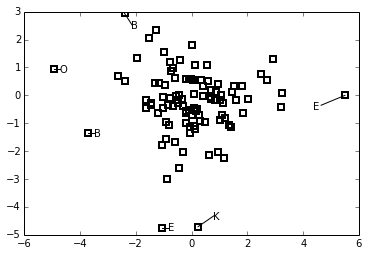

In [9]:
points = plt.plot(xx, yy, linestyle='none', marker='s', mew=2, mec='k', mfc='none')
plt.text(-4.706560478170832, 0.9353331172884595, 'O', va='center')
plt.plot([-4.9465604781708326, -4.706560478170832], [0.9353331172884595, 0.9353331172884595], 'k-')

plt.text(-3.4686632029741746, -1.3667202773545069, 'B', va='center')
plt.plot([-3.708663202974175, -3.4686632029741746], [-1.3667202773545069, -1.3667202773545069], 'k-')

plt.text(-0.8194307249812032, -4.747189445562187, 'E', va='center')
plt.plot([-1.0594307249812032, -0.8194307249812032], [-4.747189445562187, -4.747189445562187], 'k-')

plt.text(4.383441938143678, -0.3885280273244378, 'E', va='center')
plt.plot([5.498280647821097, 4.641506454272712], [-0.0014312531308891142, -0.3562699628083088], 'k-')

plt.text(-2.132139094902272, 2.5181075635997727, 'B', va='center')
plt.plot([-2.404397159418401, -2.132139094902272], [2.9374624023094507, 2.5181075635997727], 'k-')

plt.text(0.7927400507720375, -4.323302781914856, 'K', va='center')
plt.plot([0.2301594056107485, 0.7927400507720375], [-4.710399556108404, -4.323302781914856], 'k-')